In [37]:
### General
import os
import sys
import copy
import tqdm
import pickle
import random
import warnings
warnings.filterwarnings("ignore")
sys.path.append("../input/rank-gauss")
os.environ["CUDA_LAUNCH_BLOCKING"] = '1'

### Data Wrangling
import numpy as np
import pandas as pd
from scipy import stats
import gauss_rank_scaler
### Data Visualization ###
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

### Machine Learning
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import VarianceThreshold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

### Deep Learning
import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Tabnet 
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor


In [38]:
seed = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed(seed)

In [39]:
# Parameters
no_ctl = True
scale = "rankgauss"
variance_threshould = 0.7
decompo = "PCA"
ncompo_genes = 80
ncompo_cells = 10
encoding = "dummy"


In [40]:
train = pd.read_csv("New Features Datasets/train_feats_new.csv")
#train.drop(columns = ["sig_id"], inplace = True)

targets = pd.read_csv("train_targets_scored.csv")
#train_targets_scored.drop(columns = ["sig_id"], inplace = True)

#train_targets_nonscored = pd.read_csv(data_path + "train_targets_nonscored.csv")

test = pd.read_csv("New Features Datasets/test_feats_new.csv")
#test.drop(columns = ["sig_id"], inplace = True)

submission = pd.read_csv("sample_submission.csv")

In [41]:
def distributions(num, graphs, items, features, gorc):
    """
    Plot the distributions of gene expression or cell viability data
    """
    for i in range(0, num - 1, 7):
        if i >= 3:
            break
        idxs = list(np.array([0, 8, 4, 3, 57, 72,32]) + i)
    
        fig, axs = plt.subplots(1, 7, sharey = True)
        for k, item in enumerate(idxs):
            if item >= items:
                break
            graph = sns.distplot(train[features].values[:, item], ax = axs[k])
            graph.set_title(f"{gorc}-{item}")
            graphs.append(graph)

In [42]:
GENES = [col for col in train.columns if col.startswith("g-")]
CELLS = [col for col in train.columns if col.startswith("c-")]

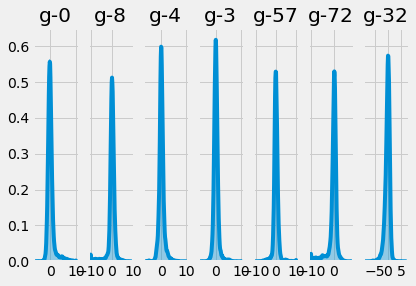

In [43]:
gnum = train[GENES].shape[1]
graphs = []

distributions(gnum, graphs, 771, GENES, "g")

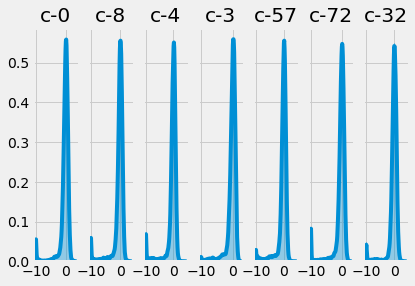

In [44]:
cnum = train[CELLS].shape[1]
graphs = []

distributions(cnum, graphs, 100, CELLS, "c")

In [45]:
data_all = pd.concat([train, test], ignore_index = True)
cols_numeric = [feat for feat in list(data_all.columns) if feat not in ["sig_id", "cp_type", "cp_time", "cp_dose"]]
mask = (data_all[cols_numeric].var() >= variance_threshould).values
tmp = data_all[cols_numeric].loc[:, mask]
data_all = pd.concat([data_all[["sig_id", "cp_type", "cp_time", "cp_dose"]], tmp], axis = 1)
cols_numeric = [feat for feat in list(data_all.columns) if feat not in ["sig_id", "cp_type", "cp_time", "cp_dose"]]

In [46]:
def scale_minmax(col):
    return (col - col.min()) / (col.max() - col.min())

def scale_norm(col):
    return (col - col.mean()) / col.std()

if scale == "boxcox":
    print(b_, "boxcox")
    data_all[cols_numeric] = data_all[cols_numeric].apply(scale_minmax, axis = 0)
    trans = []
    for feat in cols_numeric:
        trans_var, lambda_var = stats.boxcox(data_all[feat].dropna() + 1)
        trans.append(scale_minmax(trans_var))
    data_all[cols_numeric] = np.asarray(trans).T
    
elif scale == "norm":
    print(b_, "norm")
    data_all[cols_numeric] = data_all[cols_numeric].apply(scale_norm, axis = 0)
    
elif scale == "minmax":
    print(b_, "minmax")
    data_all[cols_numeric] = data_all[cols_numeric].apply(scale_minmax, axis = 0)
    
elif scale == "rankgauss":
    ### Rank Gauss ###
    print(b_, "Rank Gauss")
    scaler = GaussRankScaler()
    data_all[cols_numeric] = scaler.fit_transform(data_all[cols_numeric])
    
else:
    pass

 Rank Gauss


In [47]:
# PCA
if decompo == "PCA":
    print(b_, "PCA")
    GENES = [col for col in data_all.columns if col.startswith("g-")]
    CELLS = [col for col in data_all.columns if col.startswith("c-")]
    
    pca_genes = PCA(n_components = ncompo_genes,
                    random_state = seed).fit_transform(data_all[GENES])
    pca_cells = PCA(n_components = ncompo_cells,
                    random_state = seed).fit_transform(data_all[CELLS])
    
    pca_genes = pd.DataFrame(pca_genes, columns = [f"pca_g-{i}" for i in range(ncompo_genes)])
    pca_cells = pd.DataFrame(pca_cells, columns = [f"pca_c-{i}" for i in range(ncompo_cells)])
    data_all = pd.concat([data_all, pca_genes, pca_cells], axis = 1)
else:
    pass

 PCA


In [48]:
# Encoding
if encoding == "lb":
    print(b_, "Label Encoding")
    for feat in ["cp_time", "cp_dose"]:
        data_all[feat] = LabelEncoder().fit_transform(data_all[feat])
elif encoding == "dummy":
    print(b_, "One-Hot")
    data_all = pd.get_dummies(data_all, columns = ["cp_time", "cp_dose"])

 One-Hot


In [49]:
def distributions(num, graphs, items, features, gorc):
    """
    Plot the distributions of gene expression or cell viability data
    """
    for i in range(0, num - 1, 7):
        if i >= 3:
            break
        idxs = list(np.array([0, 1, 2, 3, 4, 5, 6]) + i)
    
        fig, axs = plt.subplots(1, 7, sharey = True)
        for k, item in enumerate(idxs):
            if item >= items:
                break
            graph = sns.distplot(data_all[features].values[:, item], ax = axs[k])
            graph.set_title(f"{gorc}-{item}")
            graphs.append(graph)

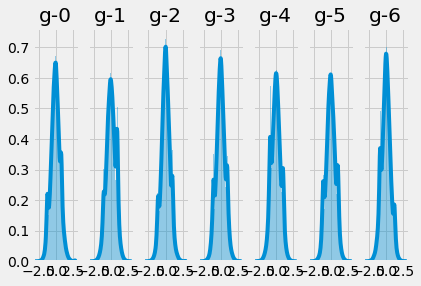

In [50]:
gnum = data_all[GENES].shape[1]
graphs = []

distributions(gnum, graphs, 771, GENES, "g")

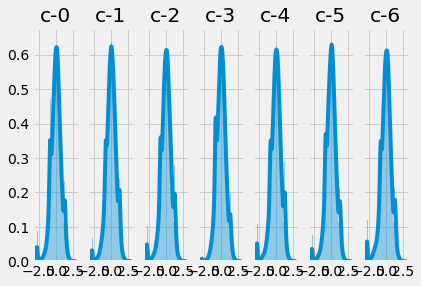

In [51]:
cnum = data_all[CELLS].shape[1]
graphs = []

distributions(cnum, graphs, 100, CELLS, "c")

In [52]:
with open("data_all.pickle", "wb") as f:
    pickle.dump(data_all, f)